# Práctica 1 - Técnicas de Procesamiento de Lenguaje Natural

Crea un script en Python que procese un texto amplio con las aplicaciones
comunes del PLN clásico: lematización, PoS tagger, parser de dependencias y sentidos de las palabras.

Para ello, utiliza el pipeline básico de la herramienta de PLN SpaCy, completado con NLTK2 para acceder a WordNet.

In [60]:
import spacy
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import csv
from nltk.corpus import wordnet as wn
from collections import Counter
import nltk
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package wordnet to /Users/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Abrir la novela level1

In [61]:
folder_path = "level1"
paragraphsVec = []

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Open each file in the folder
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    if file_name.endswith(".xml"):
        # Open and read the XML file
        with open(file_path, 'r', encoding='utf-8') as file:
            contents = file.read()
            soup = BeautifulSoup(contents, 'xml')
            
            # Extract paragraphs
            paragraphs = soup.find_all('p')
            print("Found", len(paragraphs), "paragraphs in", file_name)
            # Process each paragraph
            for paragraph in paragraphs:
                paragraph_text = paragraph.get_text()
                paragraphsVec.append(paragraph_text)
                #print(paragraph_text)

Found 2071 paragraphs in ENG18410_Sinclair.xml
Found 3107 paragraphs in ENG18400_Trollope.xml


###  Analizar el texto con el pipeline básico de SpaCy y extraer un CSV

Procesando párrafos: 100%|██████████████████████████████████████████████████████████████████████████████| 5178/5178 [01:24<00:00, 61.34it/s]


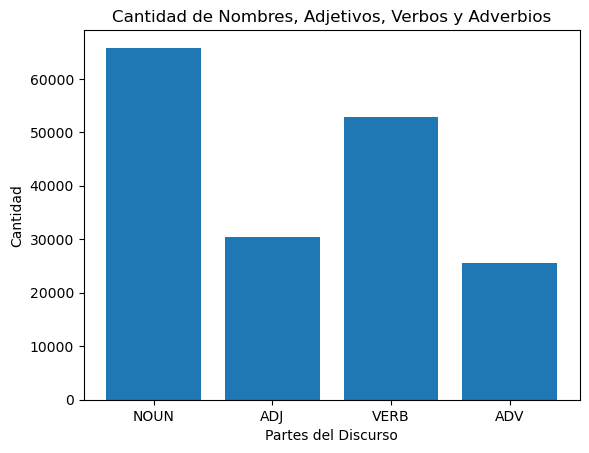

In [62]:
# Crear y escribir en el archivo CSV
pos_counts = {"NOUN": 0, "ADJ": 0, "VERB": 0, "ADV": 0}
with open('analisis_parrafos.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Palabra", "Lema", "Categoría Gramatical", "Tipo de Dependencia", "Palabra de Quien Depende"])

    for paragraph in tqdm(paragraphsVec, desc="Procesando párrafos"):
        doc = nlp(paragraph)
        for token in doc:
            text = token.text.strip()
            lemma = token.lemma_.strip()
            if token.pos_ != "SPACE": 
                if token.pos_ in pos_counts:
                    pos_counts[token.pos_] += 1
                writer.writerow([token.text, token.lemma_, token.pos_, token.dep_, token.head.text])
                
    # Crear el gráfico
plt.bar(pos_counts.keys(), pos_counts.values())
plt.xlabel('Partes del Discurso')
plt.ylabel('Cantidad')
plt.title('Cantidad de Nombres, Adjetivos, Verbos y Adverbios')
plt.show()

### Añadida la columna de significados frecuentes

In [63]:
nuevas_filas = []
lemas_frecuentes = Counter()

with open('analisis_parrafos.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader) + ["Synset Más Frecuente"]
    for row in tqdm(reader, desc="Procesando palabras"):
        palabra = row[1] 
        synsets = wn.synsets(palabra)
        synset_mas_frecuente = synsets[0].name() if synsets else "NA"
        nuevas_filas.append(row + [synset_mas_frecuente])
        lemas_frecuentes.update([palabra])
        
        
with open('analisis_parrafos_con_synsets.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(nuevas_filas)

Procesando palabras: 471556it [00:03, 136222.82it/s]


### Ampliación

In [64]:
# Crear y escribir en el archivo CSV
with open('analisis_conll.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "Text", "Lemma", "POS", "Tag", "Head ID", "Dep Rel"])
    
    for paragraph in tqdm(paragraphsVec, desc="Procesando párrafos"):
        doc = nlp(paragraph)
        for sent in doc.sents:
            for token in sent:
                if token.pos_ != "SPACE":
                    writer.writerow([token.i+1, token.text, token.lemma_, token.pos_, token.tag_, token.head.i+1, token.dep_])

Procesando párrafos: 100%|██████████████████████████████████████████████████████████████████████████████| 5178/5178 [01:21<00:00, 63.49it/s]
